<a href="https://colab.research.google.com/github/asanneh/CS109A_2019_GR31_FINAL_PROJECT/blob/master/notebook/FinalProject31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse

Helpful guide: https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c. I mounted my google drive and then unzipped the Spotify Data. I think I got everything (CSVs from 0-999). Each CSV is 11 MB, so the unzipped size of the data is 11 GB (not too terrible?). We can always run things on the GPU by going to Runtime > change runtime type > GPU. That should give more space. 

In [3]:
from google.colab import drive
drive.mount('/content/drive')# force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#load entire playlist to dataframe, note there is a performance hit here since I/O can't be parallelized
#You can limit how many rows you read in by including nrows
songs = pd.read_csv('/content/drive/My Drive/Spotify/combined_playlist.csv') #nrows = 10000000
print(f'dataset shape: {songs.shape}')
len(songs['pid'].unique())
print(f'unique playlists: {len(songs.pid.unique())}')
print(f'unique songs: {len(songs.track_uri.unique())}')
songs.head()

dataset shape: (66346428, 10)
unique playlists: 1000
unique songs: 2262292


,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,file_name
0,0,0,Sleeping At Last,spotify:track:2d7LPtieXdIYzf7yHPooWd,spotify:artist:0MeLMJJcouYXCymQSHPn8g,Chasing Cars,spotify:album:0UIIvTTWNB3gRQWFoxoEDh,242564,"Covers, Vol. 2",songs284
1,0,1,Rachael Yamagata,spotify:track:0y4TKcc7p2H6P0GJlt01EI,spotify:artist:7w0qj2HiAPIeUcoPogvOZ6,Elephants,spotify:album:6KzK9fDNmj7GHFbcE4gVJD,253701,Elephants...Teeth Sinking Into Heart,songs284
2,0,2,The Cinematic Orchestra,spotify:track:6q4c1vPRZREh7nw3wG7Ixz,spotify:artist:32ogthv0BdaSMPml02X9YB,That Home,spotify:album:5cPHT4yMCfETLRYAoBFcOZ,103920,Ma Fleur,songs284
3,0,3,The Cinematic Orchestra,spotify:track:54KFQB6N4pn926IUUYZGzK,spotify:artist:32ogthv0BdaSMPml02X9YB,To Build A Home,spotify:album:5cPHT4yMCfETLRYAoBFcOZ,371320,Ma Fleur,songs284
4,0,4,Leon Bridges,spotify:track:0NeJjNlprGfZpeX2LQuN6c,spotify:artist:3qnGvpP8Yth1AqSBMqON5x,River,spotify:album:4svLfrPPk2npPVuI4kXPYg,238560,Coming Home,songs284


In [5]:
#what identifier should we use
print(f'unique songs by uri: {len(songs.track_uri.unique())}')
print(f'unique songs by name: {len(songs.track_name.unique())}')
print('unique artist+track combos (uri):', len(songs.groupby(['track_uri', 'artist_uri'])))
print('unique artist+track combos (name):', len(songs.groupby(['track_name', 'artist_name'])))
songs.isnull().sum()
songs_nodup = songs.drop_duplicates(subset = 'track_uri') #drop all duplicated songs

counts = songs_nodup['track_name'].value_counts() #count up occurences of song names
counts


unique songs by uri: 2262292
unique songs by name: 1483760
unique artist+track combos (uri): 2262292
unique artist+track combos (name): 2189699


Intro                     1559
Silent Night               946
Home                       843
White Christmas            617
O Holy Night               554
                          ... 
Einaim Tseva Sheket          1
Broken heart                 1
Dejame Escapar               1
Burn (feat. Rick Ross)       1
Мы просто любили так         1
Name: track_name, Length: 1483759, dtype: int64

In [6]:
# look at the first 5 unique songs named 'Home' - we have different uris for each of them. 
songs_nodup.loc[songs_nodup['track_name']=='Home'][0:5]


,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,file_name
797,11,27,Susan Egan,spotify:track:66GzaMmr8iiRLOfaejUzuY,spotify:artist:7CckquWatDQSr3PFKkjM8M,Home,spotify:album:6DnTzVKb79zEtICWeIB2El,231000,Beauty And The Beast: The Broadway Musical,songs284
8325,129,149,Chris Tomlin,spotify:track:2aMb1asq5acm7cDYlFsYhY,spotify:artist:6pRi6EIPXz4QJEOEsBaA0m,Home,spotify:album:7BK26n0Gkw7bvAlAUdU53F,219720,Never Lose Sight,songs284
9235,143,33,Edward Sharpe & The Magnetic Zeros,spotify:track:7w5cxTEzp1rfV3KCy0Bd5N,spotify:artist:7giUHu5pv6YTZgSkxxCcgh,Home,spotify:album:39xrkt8RILtwa9DMyLkv32,303200,Up from Below,songs284
11036,172,0,Lady Antebellum,spotify:track:32zF5eXrb8QrUu5qNdYmIO,spotify:artist:32WkQRZEVKSzVAAYqukAEA,Home,spotify:album:4WZZDzGqjvw4bRwrp56U24,177200,Heart Break,songs284
13181,198,11,Rudimental,spotify:track:5oU43a9DI3tfV3VHwQBSQC,spotify:artist:4WN5naL3ofxrVBgFpguzKo,Home,spotify:album:2O7R7SK5zDsGeI1JpNihNE,232440,Home,songs284


I think URIs are a better way to go here - unique to each song and artist, regardless of name overlaps. Especially with cover songs - could be entirely different styles and belong in different playlists. 

count     1000.00000
mean     66346.42800
std       1677.70028
min      60532.00000
25%      65205.75000
50%      66345.00000
75%      67470.25000
max      72138.00000
Name: track_uri, dtype: float64

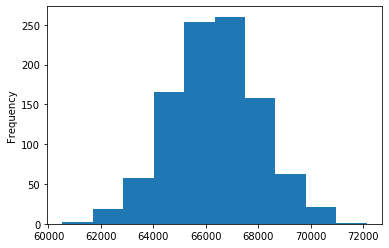

In [7]:
#what is the average length of a playlist
num_songs_in_pl = songs.groupby(by='pid').count()['track_uri']
num_songs_in_pl.plot(kind = 'hist');

num_songs_in_pl.describe()

I am using the two websites here to figure out how to make a recommender from a sparse matrix:
https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
https://jessesw.com/Rec-System/


In [0]:
#make sparse binary matrix of playlist x uniq song? 0 if song not in playlist, 1 if it is
#play_song_mat = np.zeros([len(songs0.pid.unique()), len(songs0.track_uri.unique())])
#play_song_mat.shape

n_pls = songs.pid.unique().shape[0]
n_songs = songs.track_uri.unique().shape[0]

#calculate matrix sparsity
print(f'Num playlists: {n_pls}')
print(f'Num unique songs: {n_songs}')
print(f'Sparsity: {float(songs.shape[0]) /float(n_pls*n_songs) * 100:0.3f}%')

#make sparse matrix
rows = songs.pid.astype('category').cat.codes # make category codes/indices for each playlist
cols = songs.track_uri.astype('category').cat.codes # make category codes/indices for each song
likes = np.ones(rows.shape[0]) #1s if song is in playlist

likes = sparse.csr_matrix((likes, (rows, cols)), dtype=np.float64) #make sparse matrix
print(songs.groupby(by=['pid', 'track_uri']).count()['track_name'].shape)
likes

Num playlists: 1000
Num unique songs: 2262292
Sparsity: 2.933%
